## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import IterativeImputer
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import lightgbm
from scipy.stats import zscore

## Loading 


Unique values in the data (Including Nan)

Product_id -----> 6368
Stall_no -----> 51
instock_date -----> 5350
Market_Category -----> 248
Customer_name -----> 5901
Loyalty_customer -----> 2
Product_Category -----> 10
Grade -----> 4
Demand -----> 100
Discount_avail -----> 3
charges_1 -----> 488
charges_2 (%) -----> 18
Minimum_price -----> 4237
Maximum_price -----> 4619
Selling_Price -----> 6322

Missing values in data

Product_id            0
Stall_no              5
instock_date          0
Market_Category       0
Customer_name       211
Loyalty_customer      0
Product_Category      0
Grade                 0
Demand                0
Discount_avail       38
charges_1           198
charges_2 (%)       205
Minimum_price        38
Maximum_price       343
Selling_Price        41
dtype: int64


<AxesSubplot:title={'center':'Correlation Table'}>

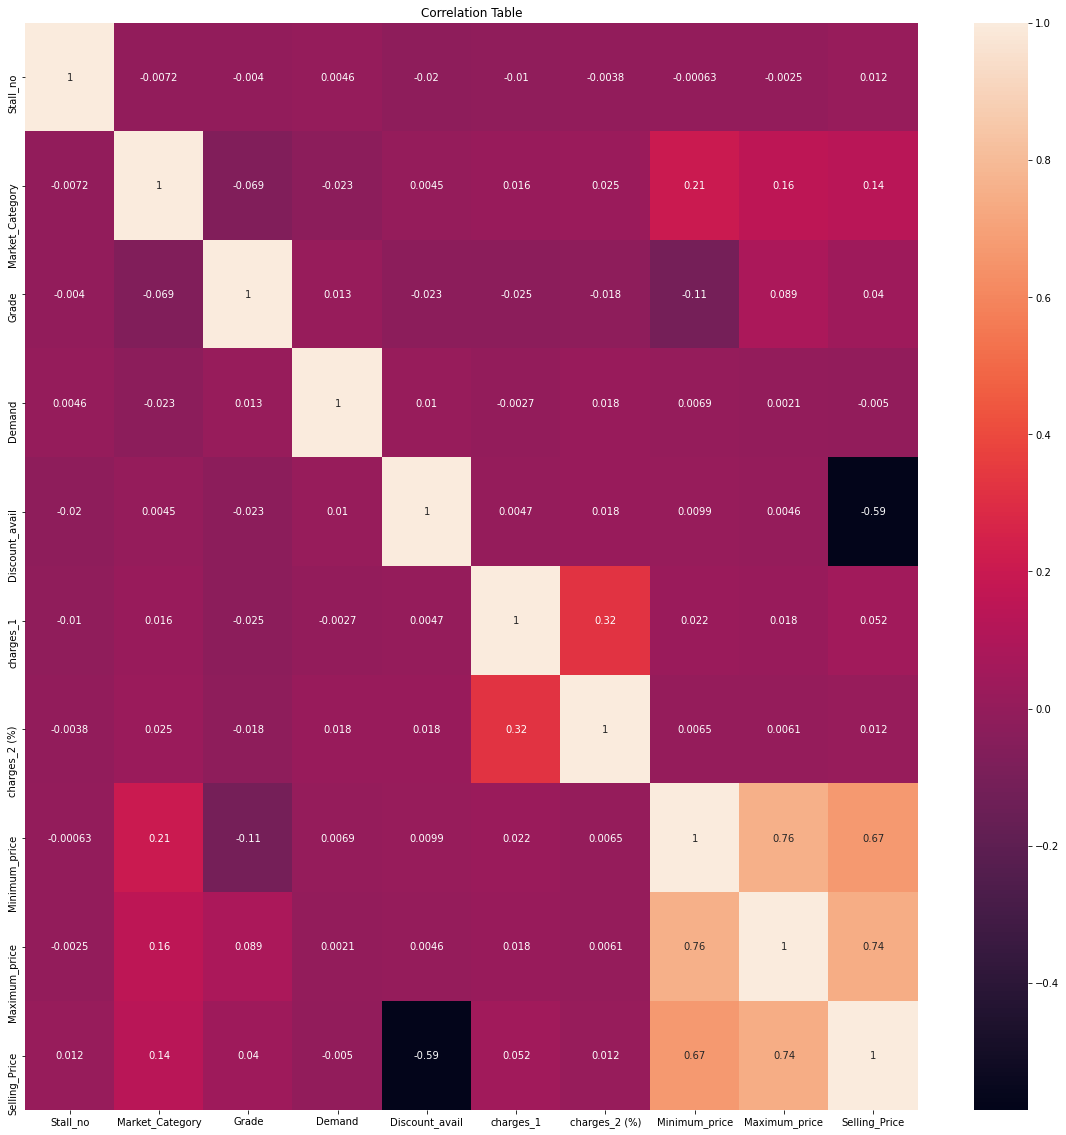

In [5]:
#load the data
train_data=pd.read_csv('./Carinival_war/dataset/train.csv')

#Unique values in each columns
print('Unique values in the data (Including Nan)\n')
for i in train_data.columns:
    print(i,'----->', len(train_data[i].unique())) 

#Missing values
print("\nMissing values in data\n")
print(train_data.isnull().sum())

plt.figure(figsize=(20,20))
plt.title('Correlation Table')
sns.heatmap(train_data.corr(method='spearman'), annot=True)



In [6]:
#preprocessing
train_data['instock_date']=pd.to_datetime(train_data['instock_date'])
train_data['year']=train_data['instock_date'].dt.year
train_data['month']=train_data['instock_date'].dt.month
train_data['day']=train_data['instock_date'].dt.day
train_data['hour']=train_data['instock_date'].dt.hour
train_data['minutes']=train_data['instock_date'].dt.minute
train_data=train_data[train_data['Selling_Price']>0]
train_data.drop(['Product_id', 'Customer_name', 'instock_date'], axis=1, inplace=True)
train_data=pd.get_dummies(train_data, columns=['Loyalty_customer', 'Product_Category'], drop_first=True)
cols=train_data.columns
train_data.dtypes

Stall_no                        float64
Market_Category                   int64
Grade                             int64
Demand                            int64
Discount_avail                  float64
charges_1                       float64
charges_2 (%)                   float64
Minimum_price                   float64
Maximum_price                   float64
Selling_Price                   float64
year                              int64
month                             int64
day                               int64
hour                              int64
minutes                           int64
Loyalty_customer_Yes              uint8
Product_Category_Cosmetics        uint8
Product_Category_Educational      uint8
Product_Category_Fashion          uint8
Product_Category_Home_decor       uint8
Product_Category_Hospitality      uint8
Product_Category_Organic          uint8
Product_Category_Pet_care         uint8
Product_Category_Repair           uint8
Product_Category_Technology       uint8


## Applying transformations and Imputation on Missing values

In [7]:

imputer=IterativeImputer()
train_data=imputer.fit_transform(train_data)
train_imp=pd.DataFrame(train_data, columns=cols)
train_imp['Minimum_price']=np.sqrt(train_imp['Minimum_price'])
train_imp['Maximum_price']=np.sqrt(train_imp['Maximum_price'])
train_imp['charges_1']=np.log2(train_imp['charges_1'])
train_imp['Stall_no']=round(train_imp['Stall_no'],0)
train_imp['Discount_avail']=round(train_imp['Discount_avail'],0)
print(train_imp.shape)

(6313, 25)


## Distribution of the train data

C:\Users\User\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



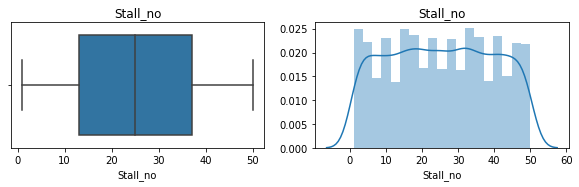

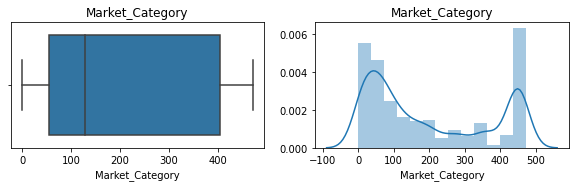

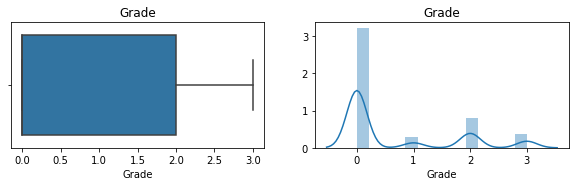

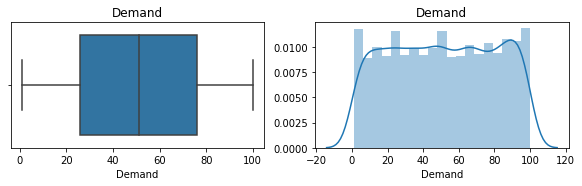

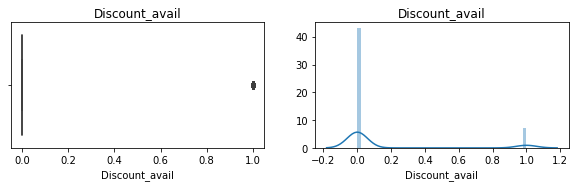

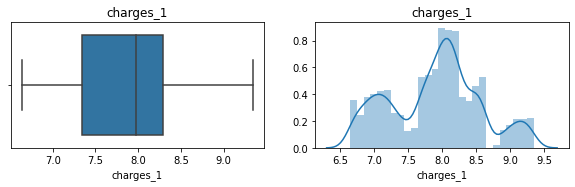

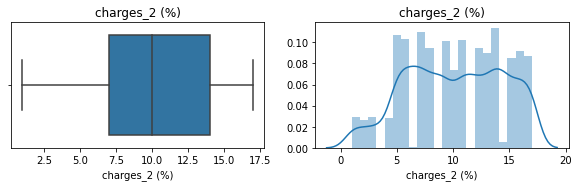

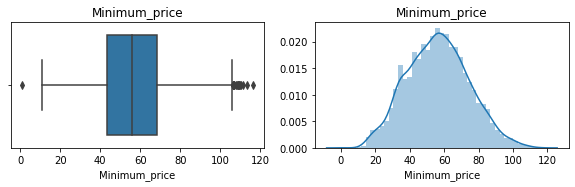

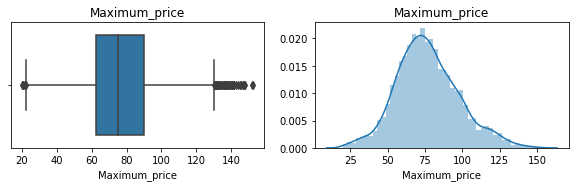

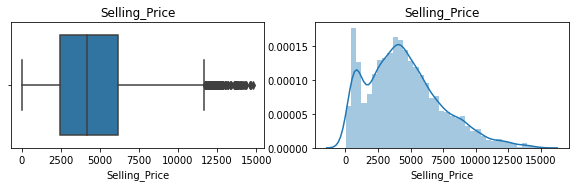

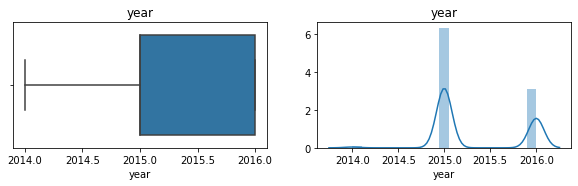

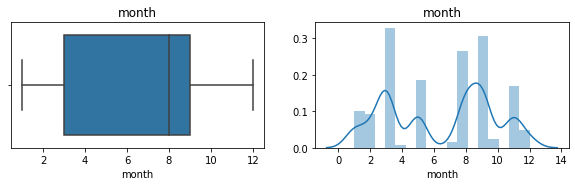

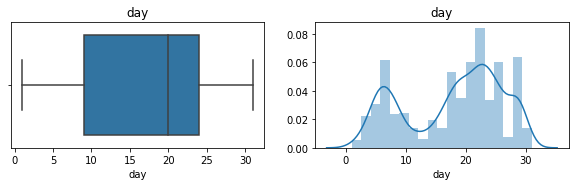

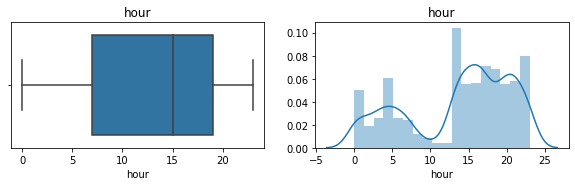

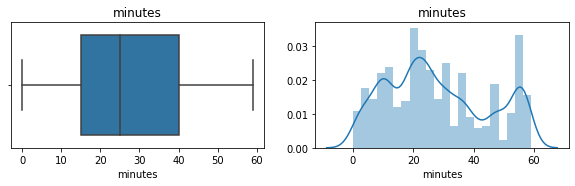

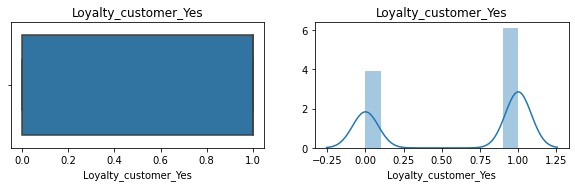

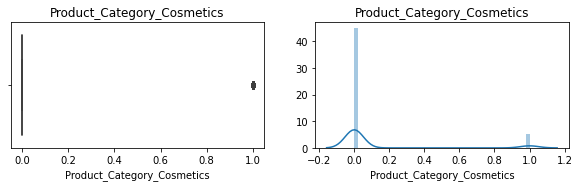

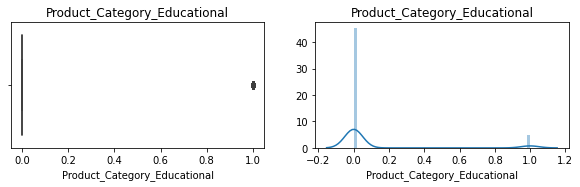

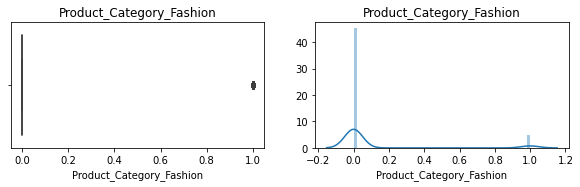

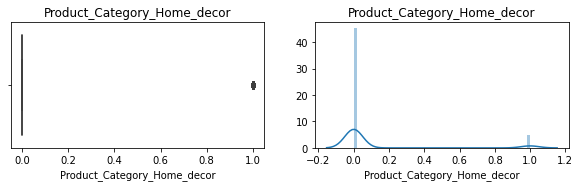

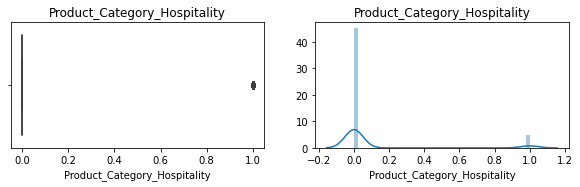

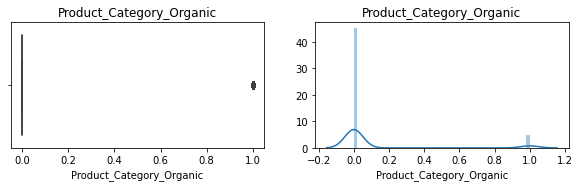

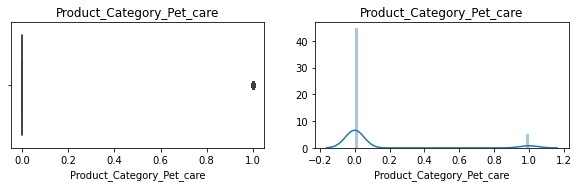

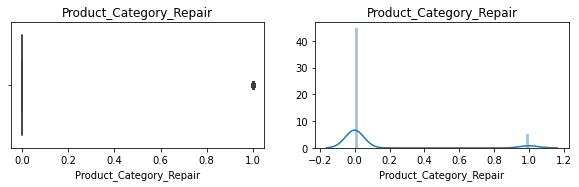

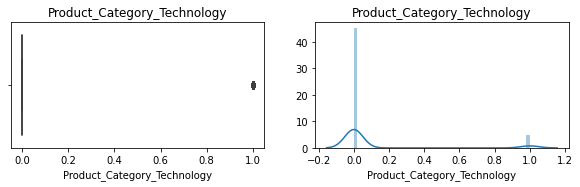

In [14]:
num=train_df.select_dtypes(include=['number'])
for y in num:
    sp_place=1
    plt.figure(figsize=(10,30))
    plt.subplot(11,2,sp_place)
    plt.title(y)
    sns.boxplot( train_df[y])
    plt.subplot(11,2,sp_place+1)
    plt.title(y)
    sns.distplot( train_df[y])
    sp_place+=1

## Removing outliers using Z-scores

In [8]:
z_scores = zscore(train_imp)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3.5).all(axis=1)
new_df = train_imp[filtered_entries]
train_df = new_df
train_df

,Stall_no,Market_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,...,Loyalty_customer_Yes,Product_Category_Cosmetics,Product_Category_Educational,Product_Category_Fashion,Product_Category_Home_decor,Product_Category_Hospitality,Product_Category_Organic,Product_Category_Pet_care,Product_Category_Repair,Product_Category_Technology
0,37.0,2.0,1.0,68.0,0.0,8.554589,11.0,54.616847,68.651293,4185.947700,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38.0,24.0,0.0,51.0,0.0,8.632995,12.0,86.573668,101.744779,9271.490256,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,447.0,0.0,10.0,0.0,7.965784,9.0,75.841941,85.492690,6785.701362,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50.0,23.0,2.0,48.0,0.0,7.169925,13.0,71.344236,144.270579,13028.917824,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.0,63.0,1.0,35.0,1.0,7.721099,4.0,49.295030,96.234090,906.553935,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308,17.0,24.0,0.0,47.0,0.0,9.262095,10.0,90.410176,106.141415,10277.520192,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6309,21.0,55.0,0.0,35.0,0.0,8.071462,5.0,59.699246,70.142712,4501.837200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6310,36.0,358.0,3.0,29.0,0.0,8.144658,3.0,72.821700,120.888378,10218.878775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6311,27.0,452.0,0.0,8.0,0.0,8.060696,3.0,65.833122,76.478755,5359.493997,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Missing values after preprocessing

In [9]:
#Missing values
print("\nMissing values in data\n")
print(train_imp.isnull().sum())


Missing values in data

Stall_no                        0
Market_Category                 0
Grade                           0
Demand                          0
Discount_avail                  0
charges_1                       0
charges_2 (%)                   0
Minimum_price                   0
Maximum_price                   0
Selling_Price                   0
year                            0
month                           0
day                             0
hour                            0
minutes                         0
Loyalty_customer_Yes            0
Product_Category_Cosmetics      0
Product_Category_Educational    0
Product_Category_Fashion        0
Product_Category_Home_decor     0
Product_Category_Hospitality    0
Product_Category_Organic        0
Product_Category_Pet_care       0
Product_Category_Repair         0
Product_Category_Technology     0
dtype: int64


## Loading,Preprocessing for test data

In [12]:
#loading
test_data=pd.read_csv('./Carinival_war/dataset/test.csv')

#Unique values in each columns
print('Unique values in the data (Including Nan)\n')
for i in test_data.columns:
    print(i,'----->', len(test_data[i].unique())) 

#Missing values
print("\nMissing values in data\n")
print(test_data.isnull().sum())

#preprocessing
prod_id=test_data['Product_id']
test_data['instock_date']=pd.to_datetime(test_data['instock_date'])
test_data['year']=test_data['instock_date'].dt.year
test_data['month']=test_data['instock_date'].dt.month
test_data['day']=test_data['instock_date'].dt.day
test_data['hour']=test_data['instock_date'].dt.hour
test_data['minutes']=test_data['instock_date'].dt.minute
test_data.drop(['Product_id', 'instock_date', 'Customer_name'], axis=1, inplace=True)
test_data=pd.get_dummies(test_data, columns=['Loyalty_customer', 'Product_Category'], drop_first=True)
cols_test=test_data.columns

Unique values in the data (Including Nan)

Product_id -----> 3430
Stall_no -----> 51
instock_date -----> 3096
Market_Category -----> 224
Customer_name -----> 3320
Loyalty_customer -----> 2
Product_Category -----> 10
Grade -----> 4
Demand -----> 100
Discount_avail -----> 2
charges_1 -----> 451
charges_2 (%) -----> 18
Minimum_price -----> 2686
Maximum_price -----> 2901

Missing values in data

Product_id           0
Stall_no             1
instock_date         0
Market_Category      0
Customer_name       53
Loyalty_customer     0
Product_Category     0
Grade                0
Demand               0
Discount_avail       0
charges_1           36
charges_2 (%)        5
Minimum_price       14
Maximum_price        0
dtype: int64


## Transformations and Imputations on test data

In [13]:
imputer=IterativeImputer()
test_data=imputer.fit_transform(test_data)
test_imp=pd.DataFrame(test_data, columns=cols_test)
test_imp['Minimum_price']=np.sqrt(test_imp['Minimum_price'])
#test_imp['Minimum_price']=test_imp[test_imp['Minimum_price']>7]
test_imp['Maximum_price']=np.sqrt(test_imp['Maximum_price'])
#test_imp['Selling_Price']=np.sqrt(test_imp['Selling_Price'])
test_imp['charges_1']=np.log2(test_imp['charges_1'])
test_imp['Stall_no']=round(test_imp['Stall_no'],0)
test_imp['Discount_avail']=round(test_imp['Discount_avail'],0)
test_imp

,Stall_no,Market_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,year,...,Loyalty_customer_Yes,Product_Category_Cosmetics,Product_Category_Educational,Product_Category_Fashion,Product_Category_Home_decor,Product_Category_Hospitality,Product_Category_Organic,Product_Category_Pet_care,Product_Category_Repair,Product_Category_Technology
0,39.0,205.0,0.0,90.0,0.0,8.569856,16.0,50.754310,57.792733,2016.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49.0,3.0,0.0,87.0,0.0,8.618386,16.0,34.669872,44.215382,2015.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,183.0,2.0,55.0,0.0,8.945444,9.0,84.705372,125.359483,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8.0,358.0,3.0,86.0,0.0,8.243174,16.0,73.511904,114.359084,2015.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33.0,167.0,0.0,27.0,0.0,9.147205,16.0,63.788714,79.018985,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,9.0,58.0,0.0,39.0,0.0,6.870365,5.0,55.623736,68.366659,2015.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3426,30.0,358.0,3.0,17.0,0.0,8.991522,6.0,58.172158,118.764473,2015.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3427,14.0,106.0,0.0,36.0,0.0,7.228819,17.0,26.645825,104.374326,2016.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3428,1.0,104.0,0.0,63.0,0.0,8.344296,15.0,38.431758,71.867934,2015.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Features and labels

In [15]:
X=train_df.drop('Selling_Price', axis=1)
y=train_df.Selling_Price


## Optimizing using the optuna

In [17]:
def objective(trial):

#parameters for tunning    
    max_depth = trial.suggest_int("max_depth", 2,20 )
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    reg_alpha=trial.suggest_float('reg_alpha', 0.1, 1)
    reg_lambda=trial.suggest_float('reg_lambda', 0.1, 1)
    num_leaves = trial.suggest_int("num_leaves", 2000, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 6, 20)
    light =LGBMRegressor(reg_alpha=reg_alpha, max_depth=max_depth, 
                         num_leaves=num_leaves, min_child_samples=min_child_samples,
                         reg_lambda=reg_lambda, xgboost_dart_mode=True, 
                         objective='regression'
                         ).fit(X, y)
    return sklearn.model_selection.cross_val_score(light, X, y, 
           n_jobs=-1, cv=10).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-12-11 15:20:37,439] A new study created in memory with name: no-name-78a5046d-b83c-4d13-b0fc-4394711f8438
[I 2020-12-11 15:20:54,140] Trial 0 finished with value: 0.9952900080115328 and parameters: {'max_depth': 17, 'n_estimators': 75, 'reg_alpha': 0.10555053927108128, 'reg_lambda': 0.3040317138012965, 'num_leaves': 2319, 'min_child_samples': 15}. Best is trial 0 with value: 0.9952900080115328.
[I 2020-12-11 15:20:57,152] Trial 1 finished with value: 0.995157570055935 and parameters: {'max_depth': 7, 'n_estimators': 114, 'reg_alpha': 0.4494342191075412, 'reg_lambda': 0.7887181960304359, 'num_leaves': 2417, 'min_child_samples': 13}. Best is trial 0 with value: 0.9952900080115328.
[I 2020-12-11 15:21:10,011] Trial 2 finished with value: 0.9952195857057179 and parameters: {'max_depth': 13, 'n_estimators': 91, 'reg_alpha': 0.14122200236353344, 'reg_lambda': 0.692734370251186, 'num_leaves': 2223, 'min_child_samples': 9}. Best is trial 0 with value: 0.9952900080115328.
[I 2020-12-11 

[I 2020-12-11 15:25:50,566] Trial 27 finished with value: 0.9953002032969243 and parameters: {'max_depth': 16, 'n_estimators': 107, 'reg_alpha': 0.24500757193012362, 'reg_lambda': 0.2194100142111669, 'num_leaves': 2813, 'min_child_samples': 14}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:26:03,951] Trial 28 finished with value: 0.9952883771256451 and parameters: {'max_depth': 18, 'n_estimators': 182, 'reg_alpha': 0.602492285354403, 'reg_lambda': 0.5172421438398198, 'num_leaves': 2288, 'min_child_samples': 12}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:26:18,856] Trial 29 finished with value: 0.9952810544444575 and parameters: {'max_depth': 17, 'n_estimators': 148, 'reg_alpha': 0.1333578557802524, 'reg_lambda': 0.3245233336131023, 'num_leaves': 2260, 'min_child_samples': 10}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:26:31,085] Trial 30 finished with value: 0.9952049571377983 and parameters: {'max_depth': 20, 'n_esti

[I 2020-12-11 15:32:14,457] Trial 54 finished with value: 0.9952695274886023 and parameters: {'max_depth': 12, 'n_estimators': 74, 'reg_alpha': 0.2654715556581077, 'reg_lambda': 0.4078159629581349, 'num_leaves': 2110, 'min_child_samples': 11}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:32:28,232] Trial 55 finished with value: 0.9952076009989176 and parameters: {'max_depth': 15, 'n_estimators': 135, 'reg_alpha': 0.5903455471873844, 'reg_lambda': 0.35243403148235264, 'num_leaves': 2057, 'min_child_samples': 7}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:32:42,006] Trial 56 finished with value: 0.995306021130858 and parameters: {'max_depth': 19, 'n_estimators': 115, 'reg_alpha': 0.622713403307827, 'reg_lambda': 0.5094536502041089, 'num_leaves': 2170, 'min_child_samples': 12}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:32:55,083] Trial 57 finished with value: 0.9952097994264483 and parameters: {'max_depth': 20, 'n_estimat

[I 2020-12-11 15:38:08,935] Trial 81 finished with value: 0.9953159945891292 and parameters: {'max_depth': 18, 'n_estimators': 133, 'reg_alpha': 0.38975024387443674, 'reg_lambda': 0.4179843976153257, 'num_leaves': 2244, 'min_child_samples': 10}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:38:21,603] Trial 82 finished with value: 0.9952859617174434 and parameters: {'max_depth': 19, 'n_estimators': 131, 'reg_alpha': 0.41273588892651036, 'reg_lambda': 0.41484030893355917, 'num_leaves': 2244, 'min_child_samples': 11}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:38:34,576] Trial 83 finished with value: 0.9953243580560619 and parameters: {'max_depth': 17, 'n_estimators': 140, 'reg_alpha': 0.5312558777529366, 'reg_lambda': 0.4734070405316625, 'num_leaves': 2199, 'min_child_samples': 10}. Best is trial 22 with value: 0.9953370620043289.
[I 2020-12-11 15:38:49,560] Trial 84 finished with value: 0.9952817943140099 and parameters: {'max_depth': 18, 'n_e

Accuracy: 0.9953370620043289
Best hyperparameters: {'max_depth': 20, 'n_estimators': 145, 'reg_alpha': 0.23361133650695767, 'reg_lambda': 0.3646820142372002, 'num_leaves': 2133, 'min_child_samples': 12}


## Paramaters that tuned the model (Noted after each notable increase in models generalization)

In [ ]:
#Accuracy: 0.9938415085452934
#Best hyperparameters: {'reg_alpha': 0.7456109173327894, 'reg_lambda': 0.3513017957976875} 

#Accuracy: 0.9939495094697293
#Best hyperparameters: {'reg_alpha': 0.5274989807836419, 'reg_lambda': 0.48647944707380364, 'num_leaves': 168, 'max_depth': 13}

#Accuracy: 0.9939713774056355
#Best hyperparameters: {'reg_alpha': 0.6137386742175541, 'reg_lambda': 0.7814261021583319, 'num_leaves': 200, 'max_depth': 11, 'subsample': 0.16428327312110647}  
    
#Accuracy: 0.99447700619376
#Best hyperparameters: {'max_depth': 9, 'n_estimators': 75, 'reg_alpha': 0.36600749188158427, 'reg_lambda': 0.858767733980454, 'num_leaves': 1912, 'min_child_samples': 8}
    
#Accuracy: 0.994561907361138
#Best hyperparameters: {'max_depth': 10, 'n_estimators': 84, 'reg_alpha': 0.12891327040010356, 'reg_lambda': 0.6991573276577925, 'num_leaves': 2404, 'min_child_samples': 8}    
    
#Accuracy: 0.9945821581506452 #objective=regression, xgboost_dart_mode=True
#Best hyperparameters: {'max_depth': 10, 'n_estimators': 92, 'reg_alpha': 0.9353032815828701, 'reg_lambda': 0.6022321283964343, 'num_leaves': 2839, 'min_child_samples': 8}

#Accuracy: 0.9953370620043289
#Best hyperparameters: {'max_depth': 20, 'n_estimators': 145, 'reg_alpha': 0.23361133650695767, 'reg_lambda': 0.3646820142372002, 'num_leaves': 2133, 'min_child_samples': 12}

In [18]:
set_params={'max_depth': 20, 
            'n_estimators': 145, 
            'reg_alpha': 0.23361133650695767, 
            'reg_lambda': 0.3646820142372002, 
            'num_leaves': 2133, 
            'min_child_samples': 12}
light=LGBMRegressor(**set_params).fit(X,y)
pred=light.predict(test_imp)


## Distribution of the predicted with the Selling price

<AxesSubplot:xlabel='Selling_Price'>

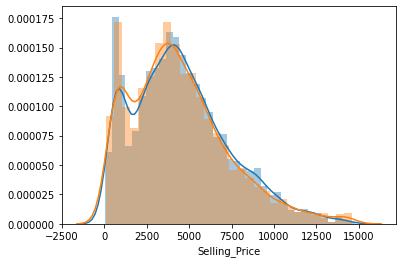

In [19]:
sns.distplot(y)
sns.distplot(pred)

## Submission

In [21]:
sell_price=pd.Series(pred)
submission=pd.DataFrame(data=[prod_id, sell_price]).T
submission.columns=['Product_id', 'Selling_Price']
submission.to_csv('F:\my_submission_file(CW).csv',index=False)
submission

,Product_id,Selling_Price
0,SCHE4YSTDVPVZVXW,3379.93
1,ACCEGCATKHNRXUHW,1977.54
2,NKCE6GJ5XVJDXNNZ,11834.2
3,NKCEB8BK3ZXDHDHM,9474.06
4,TOPEFDXSAHRNPF94,5734.42
...,...,...
3425,BBAE9K7BXFUTDNBK,3980.8
3426,RTRDYPA4PJHCJCGF,9120.35
3427,TUNE8FWQBS7TVVT7,6345.7
3428,NKCEGMUABCRGUZPE,3533.88
